# Inverse Problems : The Bayesian Approach

This numerical tour follows a Bayesian approach in Inverse Problems. By using explicit convex prior distributions, our aim is to perform image deconvolution and uncertainty quantification using a [Langevin algorithm](https://hal.science/hal-01267115/document) for sampling.

In [50]:
import math
import numpy as np
import time as time

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

from tqdm.auto import tqdm
from PIL import Image

import large_scale_UQ as luq
import skimage as ski
import matplotlib.pyplot as plt

import sys
sys.path.append('/disk/xray0/tl3/repos/sampling-tutorials/')
from functions import *


# Check if there's a GPU available and run on GPU, otherwise run on CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
1
0
NVIDIA A100-PCIE-40GB


## Introduction

For many problems in imaging, we are interested in recovering an image  $x \in \mathbb{R}^d$, from a set of measurements $y \in \mathbb{R}^d$.

We consider measurement models of the form 

$$y = Ax + w,$$ 

where $A \in \mathbb{R}^{d \times d}$ is a linear operator and $w \sim N(0, \sigma^2 I_d)$ is a noise term.  Here, we study the case where both $A$ and $\sigma>0$ are known.  The recovery of $x$ from $y$ is often ill posed or ill conditioned, so we regularize with prior information.

The measurement model defines a likelihood function $p(y|x)\propto e^{-f_{y}(x)}$, where $f_{y}$ (negative log-likelihood) is convex and continuously differentiable with $L_{y}$-Lipschitz gradient. The regularization will take the form of a prior distribution $p(x)\propto e^{-\theta g(x)}$, where $g: \mathbb{R}^{d} → \mathbb{R}$ is a proper, lower semi-continuous and convex function but potentially nonsmooth. The parameter $\theta$ is the regularisation parameter that controls the amount of regularity enforeced by the prior. Then, from the Bayes Theorem, the posterior distribution $p(x|y;\theta)$ is defined as

$$p(x|y)\propto p(y|x)p(x) = e^{-f_{y}(x)-\theta g(x)}\,\,.$$

Our aim here is to calculate the Minimum Mean Square Error (MMSE) Bayesian estimator defined as

$$\hat{x}_{MMSE} = \operatorname{argmin}_{u\in\mathbb{R}^{d}}\mathbb{E}\left[||x-u||^{2}|y\right]= \mathbb{E}(x|y) = \int_{\mathbb{R}^{d}}\tilde{x}p(\tilde{x}|y)d\tilde{x}.$$

Moreover, as an illustration of an uncertainty visualisation analysis, we also calculate the posterior variance for each image pixel $x_{i}$, for $i = 1,\ldots,d$, defined as

$$Var(x_i|y) = \mathbb{E}(x_i^{2}|y) - (\mathbb{E}(x_i|y))^{2},$$

where

$$\mathbb{E}(x_i^{2}|y)=\int_{\mathbb{R}^{d}}\tilde{x_i}^{2}p(\tilde{x_i}|y)d\tilde{x_i}.$$

## Loading and Blurring the Image
Deconvolution corresponds to removing a blur from an image. First we load the image to be used for the rest of the notebook.

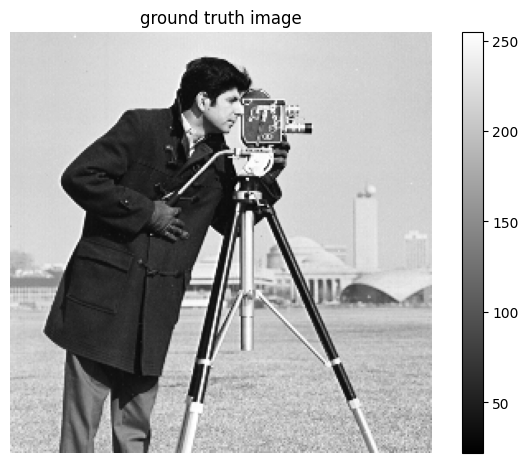

In [2]:
data_dir = '/disk/xray0/tl3/repos/sampling-tutorials/'

# Load grayscale image
im = np.array(Image.open(data_dir+"cman.png")) 
plot_im(im, "ground truth image")

# Convert to torch tensor
x = torch.Tensor(im/255.).to(device)

Define the convolution kernel A. Here a 5x5 uniform blur is used. The `blur_operators()` function returns the functions handles $A$ and $A^T$ that implement the forward operations $Ax$ and $A^Tx$ respectively (computed by calling A(x) and AT(x)) as well as the spectral norm $||AA^T||_{2}^{2}$.

The calculation of $||AA^T||_{2}^{2}$ is necessary since it appears in the Lipschitz constant of the model and plays a role for the stepsize of the presented algorithms.

In [3]:
kernel_len = [5,5]
size = [im.shape[0],im.shape[1]]
type_blur = "uniform"
A, AT, AAT_norm = blur_operators(kernel_len, size, type_blur, var = None)

Apply the filter and add some noise to obtain the measurements $y = Ax + w$ and achieve a blurred signal-to-noise ratio (BSNR) of $40$ dB.

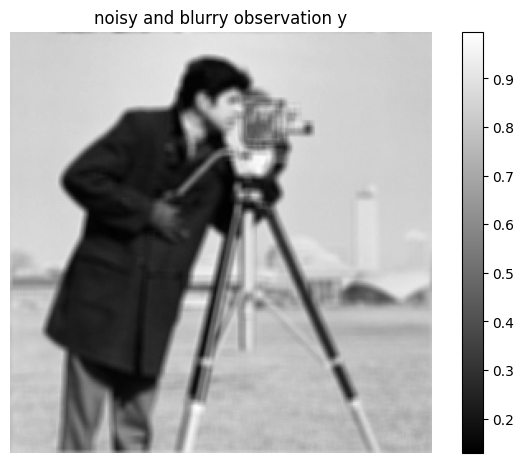

In [4]:
y0 = A(x)

BSNRdb = 40
sigma = torch.linalg.matrix_norm(A(x)-torch.mean(A(x)), ord='fro')/math.sqrt(torch.numel(x)*10**(BSNRdb/10))

y = y0 + sigma * torch.randn_like(x)
plot_im(y, "noisy and blurry observation y")

# Markov Chain Monte Carlo (MCMC) methods in imaging inverse problems

It is clear that the calculation of the integrals defined above is a computationally infeasible task in high dimensions. Stochastic simulation algorithms, namely Markov Chain Monte Carlo (MCMC) algorithms, estimate these integrals by sampling. For example, if we could get i.i.d samples $\{X_{i}\}_{i=1}^{N}$ from $p(x|y;\theta)$ the posterior mean is approximated by

$$\hat{x}_{MMSE}\approx\dfrac{1}{N}\sum_{i=1}^{N}X_{i},$$

with the Monte Carlo approximation error vanishing as $N → ∞$.

The question that arises here is how can we sample from the posterior? Under a smooth prior, a common approach is to solve the overdamped Langevin stochastic differential equation (SDE)

$$dX_{t} = \nabla \log p(X_{t}|y;\theta) + \sqrt{2}W_{t}=
\nabla \log p(y|X_{t}) + \nabla \log p(X_{t}|\theta)+ \sqrt{2}W_{t}$$

where $(W_{t})_{t\geq0}$ is a d-dimensional Brownian motion. Under mild conditions, the above SDE has a unique strong solution $(X_{t})_{t>0}$ that admits the posterior of interest $p(x|y;\theta)$ as its  unique stationary density.

In general one cannot solve the overdamped Langevin SDE analytically and needs to resort to the use of numerical methods. The simplest numerical method one can employ is the Euler-Maruyama method, which gives rise to the unadjusted Langevin algorithm (ULA), which defines a Markov Chain $\{ X_{k},  k \in \mathbb{N}\}$ using the following one step recursion 


$$X_{k+1} = X_{k} + \delta\nabla \log p(y|X_{k}) + \delta\nabla \log p(X_{k}|\theta)+ \sqrt{2\delta}Z_{k+1}\,\,,$$

where $\{Z_{k} : k\in \mathbb{N}\}$ is a family of i.i.d Gaussian random variables with zero mean and identity covariance matrix and $\delta$ is the time-step.

## Likelihood

Since, we assumed Gaussian noise, the likelihood $p(y|x)$ is Gaussian given from the forward model $y = Ax + w$. Here we keep track of the negative log-likelihood $-\log p(y|x) = f_y(x) =\dfrac{1}{2\sigma^2}||y-Ax||^{2}_{2}$.

In [5]:
f = lambda x,A : (torch.linalg.matrix_norm(y-A(x), ord='fro')**2.0)/(2.0*sigma**2)

Define the gradient of the negative log-likelihood $f_{y}$.
$$\nabla f_y(x) = A^T(Ax - y).$$

In [6]:
gradf = lambda x,A,AT : AT(A(x)-y)/sigma**2

The Lipschitz constant $L_{y}$ related to the specific likelihood's gradient (useful for the stepsize choice) is $\dfrac{||AA^T||_2}{\sigma^2}$. We calculated $||AA^T||_2$ earlier.

In [7]:
L_y = AAT_norm/(sigma**2)

## Define a prior

Regularisation terms which are traditionally used for inverse problems are typically nonsmooth as this promotes solutions with some desired properties such as sparsity or edge preservation. The posterior $p(x|y;\theta)$ is then also nonsmooth because the prior $p(x|\theta)$ is not smooth.

In this context, the gradient $x\mapsto\nabla_x\log p(x|\theta)$ is not available and we need an approximation of $\tilde{g}(x)=\theta g(x)=-\log p(x|\theta)$. To smooth $\tilde{g}$, we consider its Moreau-Yosida (MY) envelope defined as

$$\tilde{g}^{\lambda}(x)=\min_{u\in\mathbb{R}^{d}}\{\tilde{g}(u)+(2\lambda)^{-1}||u-x||^{2}\}$$

The Moreau Yosida envelope $\tilde{g}^{\lambda}$ is gradient Lipschitz with the Lipschitz constant $L_{\tilde{g}^{\lambda}}= \dfrac{1}{\lambda}$. The gradient  of $\tilde{g}^\lambda$ is given by

$$\nabla \tilde{g}^{\lambda}(x)=\lambda^{-1}(x-\mathrm{prox}_{\tilde{g}}^{\lambda}(x)),$$

where 

$$\mathrm{prox}_{\tilde{g}}^{\lambda}(x)=\mathrm{prox}_{g}^{\theta\lambda}(x)=\arg\min_{u\in\mathbb{R}^{d}}\left\{\theta g(u)+\dfrac{1}{2\lambda}||u-x||^{2}\right\}$$
is the proximal operator of $g$. Therefore instead of approximating the overdamped Langevin for $p(x|y)$ we consider 
$$
dX_t = \nabla f_y(x)dt + \lambda^{-1}(x-\mathrm{prox}_{g}^{\theta\lambda}(x))dt+ \sqrt{2}W_{t}.
$$

In this tour, we consider a prior distribution based on the total variation (TV) norm and given by

$$p(x) \propto e^{- \theta ||x|| _{TV}}\,\,,$$

where the total variation norm $||x|| _{TV}$ is defined as $$g(x)=||x|| _{TV}=\sum_{i,j}^{}\sqrt{|x_{i+1,j}-x_{i,j}|^2+|x_{i,j+1}-x_{i,j}|^2}.$$
The intuition behind TV norm is that it preserves the edges and smooths the flat regions of the image. Besides, we recall that the parameter $\theta$ controls the amount of regularity enforced by the prior. The function `g_fun_theta()` calculates the $\theta||\cdot|| _{TV}$.

Although we assumed the parameter $\theta$ is known in this tour, we can calibrate $\theta$ online by implementing the SAPG algorithm [SAPG](https://epubs.siam.org/doi/pdf/10.1137/20M1339829 "Read more about SAPG") (see also [SAPG notebook](https://epubs.siam.org/doi/pdf/10.1137/20M1339829 "Add link to the SAPG notebook")).

In [8]:
theta = 0.047*255.
g_fun_theta = lambda x : theta*tv(Grad_Image(x))                    

In [9]:
# Define the wavelet dict
wavs_list = ['db8'] # ["db1", "db4"] 
levels = 4
# Define the l1 norm with dict psi
# gamma = torch.max(torch.abs(psi.dir_op(y_torch))) * reg_param
psi = luq.operators.DictionaryWv_torch(wavs_list, levels)

h = luq.operators.L1Norm_torch(1., psi, op_to_coeffs=True)
gamma = h._get_max_abs_coeffs(h.dir_op(torch.clone(y))) * theta
h.gamma = gamma
h.beta = 1.0

g_fun_theta = lambda x : h._fun_coeffs(h.dir_op(x))


The function $g(x)=||\cdot||_{TV}$ is not a smooth function. We consider the Moreau-Yosida (MY) enveloppe as we discussed above.

The function `proxg()` below calculates the proximity operator when $g(x)=||\cdot||_{TV}$,

$$\operatorname{prox}_{g}^{\lambda}(x)=\operatorname{argmin}_{u\in\mathbb{R}^{M}}\{||u||_{TV}+(2\lambda)^{-1}||u-x||^{2}\}\,\,.$$

The function `gradg()` calculates $$\nabla g^{\lambda}(x)=\lambda^{-1}(x-\operatorname{prox}_{g}^{\lambda}(x))\,\,.$$

The parameter $\lambda$ is chosen to be equal to $\alpha L^{-1}_{y}$, where $\alpha \in (0,1)$.

In [10]:
lambda_prox = 1/L_y
lambd_frac = 0.99
lambd = lambda_prox*lambd_frac

proxg = lambda x: chambolle_prox_TV(x,{'lambda' : theta*lambd, 'MaxIter' : 25})
gradg = lambda x: (x -proxg(x))/lambd 

In [11]:
theta

11.985

In [12]:

proxg = lambda x: h.adj_op(h.prox(h.dir_op(torch.clone(x)), lambd))
gradg = lambda x: (x -proxg(x))/lambd 


## Define the log-posterior and its gradient
The $\log$ posterior is given by 
$$\log p^{\lambda}(x|y;\theta) = f(x) - \theta g^{\lambda}(x)$$
and its gradient $x \mapsto \nabla_x\log p^{\lambda}(x|y;\theta)$ is difined as
$$\nabla_x\log p^{\lambda}(x|y;\theta) = -\nabla_xf(x) - \theta \nabla_x g^{\lambda}(x)$$

In [13]:
logPi = lambda z:  (- f(z,A) - g_fun_theta(z))
grad_f_g = lambda x: gradf(x,A,AT) + gradg(x)

## MYULA Algorithm

As mentioned before our aim is to calculate the posterior mean as
$$\hat{x}_{MMSE} = \mathbb{E}(x|y) = \int_{\mathbb{R}^{d}}\tilde{x}p(\tilde{x}|y)d\tilde{x}\approx \dfrac{1}{N}\sum_{i=1}^{N}X_{i}$$

and the posterior variance for each image pixel $x_{i}$, for $i = 1,\ldots,d$, as

$$\operatorname{Var}(x_i|y) = \mathbb{E}(x_i^{2}|y) - (\mathbb{E}(x_i|y))^{2} \approx \dfrac{1}{N}\sum_{i=1}^{N}X_{i}^2 - \left(\dfrac{1}{N}\sum_{i=1}^{N}X_{i}\right)^2\,\,.$$

Additionally:

1) We are keeping track of the reconstruction quality of the MMSE estimate by calculating the Normalized Mean Square Error (NRMSE), the Peak-Signal-to-Noise Ratio (PSNR) and the Structural Similarity Index Measure (SSIM) w.r.t. the ground truth image.

2) We are keeping track of the log-posterior.

### MYULA kernel updates

Under a smoothed $\log p^{\lambda}(X_{k}|\theta)$, we get the Moreau-Yosida ULA (MYULA) algorithm:

$$X_{k+1} = X_{k} - \delta\nabla f_{y}(X_k) - \frac{\delta}{\lambda}\left(X_k-\operatorname{prox}_{\tilde{g}}^{\lambda}(X_k)\right) + \sqrt{2\delta}Z_{k+1}.$$

In [14]:
def ULA_kernel(X, delta):
    return X - delta * grad_f_g(X) + math.sqrt(2*delta) * torch.randn_like(X)

### Setting the stepsize

Since an MCMC algorithm needs to be implemented- as this is explained above - we will need to choose the step-size $\delta$. In order to converge, we need to take $\delta < 2/L$ where $L=L_{y} + L_{\tilde{g}^{\lambda}}$ with $L_{y}$ being the Lipschitz constant of $f_{y}$ and $L_{\tilde{g}^{\lambda}}$ the Lipschitz constant of $\tilde{g}^{\lambda}$ which is equal to $\lambda^{-1}$.

We will consider $\delta = 1/L$.

In [15]:
L_g = 1/lambd
L = L_y+L_g
delta = 1/L

### Algorithm choices and initializations

Choose the number of sampling iterations, here it is $10^{5}$. A burn-in period of $5\%$ is also included.  The Markov chain is initialized with the observation $y$. In total, we would like to save a trace of 2000 samples, so we set the thinning variable accordingly. In practice, you will need to run the sampling for longer (500k-1mio iterations), but this is enough to illustrate how it works.

In [16]:
maxit = 10000
burnin = np.int64(maxit*0.05)
n_samples = np.int64(2000)
X = y.clone()
MC_X = []
thinned_trace_counter = 0
thinning_step = np.int64(maxit/n_samples)

### Quality metrics
Keep track of the NRMSE, PSNR, SSIM w.r.t. to the ground truth image and the log-posterior on the fly.

In [17]:
nrmse_values = []
psnr_values = []
ssim_values = []
log_pi_trace = []

### The Algorithm in Practice

1. Each iteration is calculated using the MYULA kernel.

2. After the burning-period we start calculating the posterior sample mean and variance on the fly by updating them in each iteration. We are using the `welford` class for this. The `update()` function of the class updates the sample mean and variance in each iteration.

3. We also keeping track of the samples in the Fourier domain calculating respective the posterior mean and variance on the fly in the Fourier domain. This can be accomplished by just giving as input in the `welford` class the absolute value of the FT of the samples.


In [18]:
start_time = time.time()
for i_x in tqdm(range(maxit)):

    # Update X
    X = ULA_kernel(X, delta)

    if i_x == burnin:
        # Initialise recording of sample summary statistics after burnin period
        post_meanvar = welford(X)
        absfouriercoeff = welford(torch.fft.fft2(X).abs())
        count=0
    elif i_x > burnin:
        # update the sample summary statistics
        post_meanvar.update(X)
        absfouriercoeff.update(torch.fft.fft2(X).abs())

        # collect quality measurements
        current_mean = post_meanvar.get_mean()
        nrmse_values.append(NRMSE(x, current_mean))
        psnr_values.append(PSNR(x, current_mean))
        ssim_values.append(SSIM(x, current_mean))
        log_pi_trace.append(logPi(X).detach().item())

        # collect thinned trace
        if count == thinning_step-1:
            MC_X.append(X.detach().cpu().numpy())
            count = 0
        else:
            count += 1

end_time = time.time()
elapsed = end_time - start_time       

  0%|          | 0/10000 [00:00<?, ?it/s]

Evaluate metrics of noisy image $y$.


In [19]:
print(f"Initial NRMSE: {NRMSE(x,y):.4f}")
print(f"Initial PSNR: {PSNR(x,y):.2f} dB")
print(f"Initial SSIM: {SSIM(x,y):.4f}")

Initial NRMSE: 0.1174
Initial PSNR: 21.61 dB
Initial SSIM: 0.6957


Evaluate metrics of posterior mean.


In [20]:
print(f"Result NRMSE: {NRMSE(post_meanvar.get_mean(),x):.4f}" )
print(f"Result PSNR: {PSNR(post_meanvar.get_mean(),x):.2f} dB")
print(f"Result SSIM: {SSIM(post_meanvar.get_mean(),x):.4f}")

Result NRMSE: 0.0683
Result PSNR: 26.35 dB
Result SSIM: 0.8324


In [21]:
y.shape

torch.Size([256, 256])

## Plotting Results
We display below the ground truth and noisy and blurry image, the posterior mean (**MMSE** solution of the inverse problem), the posterior variance (which is useful for quantifying the uncertainties) and further statistics in the second row. More specifically, we display ratios of the posterior mean over the posterior standard deviation (SD, taking the root of the variance) as well as the ratio of the SD over the posterior mean in the spatial domain (so called coefficients of variation), and the mean and variance in log scale in Fourier domain. The following row shows the image quality metrics (NMRSE, PSNR, SSIM) for the cumulative mean, which tells us about the convergence of the algorithm (when the curves are completely flattened out). Last but not least, we display the trace of $\log \pi$ which gives an indication about how well the chain is mixing and whether it has reached stationarity (in which case the chain will hover around a range of values).

In [22]:
def plots(x,y,post_meanvar,post_meanvar_absfourier, nrmse_values, psnr_values, ssim_values, logPi_trace):
    
    post_mean_numpy = post_meanvar.get_mean().detach().cpu().squeeze().numpy()
    post_var_numpy = post_meanvar.get_var().detach().cpu().squeeze().numpy()
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (15,10))
    fig.tight_layout(pad=.01)
    
    # --- Ground truth
    plot1 = plt.figure()
    axes[0,0].imshow(x.detach().cpu().squeeze().numpy(), cmap="gray")
    axes[0,0].set_title('Ground truth image')
    axes[0,0].axis('off')
    plt.close()

    # --- Blurred
    plot1 = plt.figure()
    axes[0,1].imshow(y.detach().cpu().squeeze().numpy(), cmap="gray")
    axes[0,1].set_title('Blurred noisy image')
    axes[0,1].axis('off')
    plt.close()

    # --- MMSE
    plot1 = plt.figure()
    axes[0,2].imshow(post_mean_numpy, cmap="gray")
    axes[0,2].set_title('x - posterior mean')
    axes[0,2].axis('off')

    # --- Variance
    axes[0,3].imshow(post_var_numpy, cmap="gray")
    axes[0,3].set_title('x - posterior variance')
    axes[0,3].axis('off')
    plt.close()

    # --- MMSE / Var
    plot1 = plt.figure()
    axes[1,0].imshow(post_mean_numpy/np.sqrt(post_meanvar.get_var().detach().cpu().squeeze().numpy()), cmap="gray")
    axes[1,0].set_title('x - posterior mean/posterior SD')
    axes[1,0].axis('off')
    plt.close()

    # --- Var / MMSE
    plot1 = plt.figure()
    axes[1,1].imshow(np.sqrt(post_var_numpy)/post_mean_numpy,cmap="gray")
    axes[1,1].set_title('x - Coefs of variation')
    axes[1,1].axis('off')
    plt.close()

    # --- Mean Fourier coefs
    plot1 = plt.figure()
    axes[1,2].imshow(torch.log(post_meanvar_absfourier.get_mean()).detach().cpu().squeeze().numpy())
    axes[1,2].set_title('Mean coefs (log-scale)')
    axes[1,2].axis('off')
    plt.close()
    
    # --- Variance Fourier coefs
    plot1 = plt.figure()
    axes[1,3].imshow(torch.log(post_meanvar_absfourier.get_var()).detach().cpu().squeeze().numpy())
    axes[1,3].set_title('Var coefs (log-scale)')
    axes[1,3].axis('off')
    plt.close()
                
    # --- NRMSE ---                
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
    fig.tight_layout(pad=.01)
    
    plot1 = plt.figure()
    axes[0].plot(np.arange(len(nrmse_values))[::10], nrmse_values[::10], label =  "-- NRMSE --")
    axes[0].set_title('NRMSE of $X$ vs $x_{gr}$')
    axes[0].legend()
    plt.close()
    
    # --- PSNR ---
    plot1 = plt.figure()
    axes[1].plot(np.arange(len(psnr_values))[::10], psnr_values[::10], label =  "-- PSNR --")
    axes[1].set_title('PSNR of $X$ vs $x_{gr}$')
    axes[1].legend()
    plt.close()

    # --- SSIM ---
    plot1 = plt.figure()
    axes[2].plot(np.arange(len(ssim_values))[::10],ssim_values[::10], label =  "-- SSIM --")
    axes[2].set_title('SSIM of $X$ vs $x_{gr}$')
    axes[2].legend()
    plt.close()
                     
    # --- log pi
    plot = plt.figure(figsize = (15,10))
    
    plt.plot(np.arange(len(logPi_trace))[::10],logPi_trace[::10], label =  "- $\log \pi$ -")
    plt.legend()
    plt.show()
    plt.close()
    

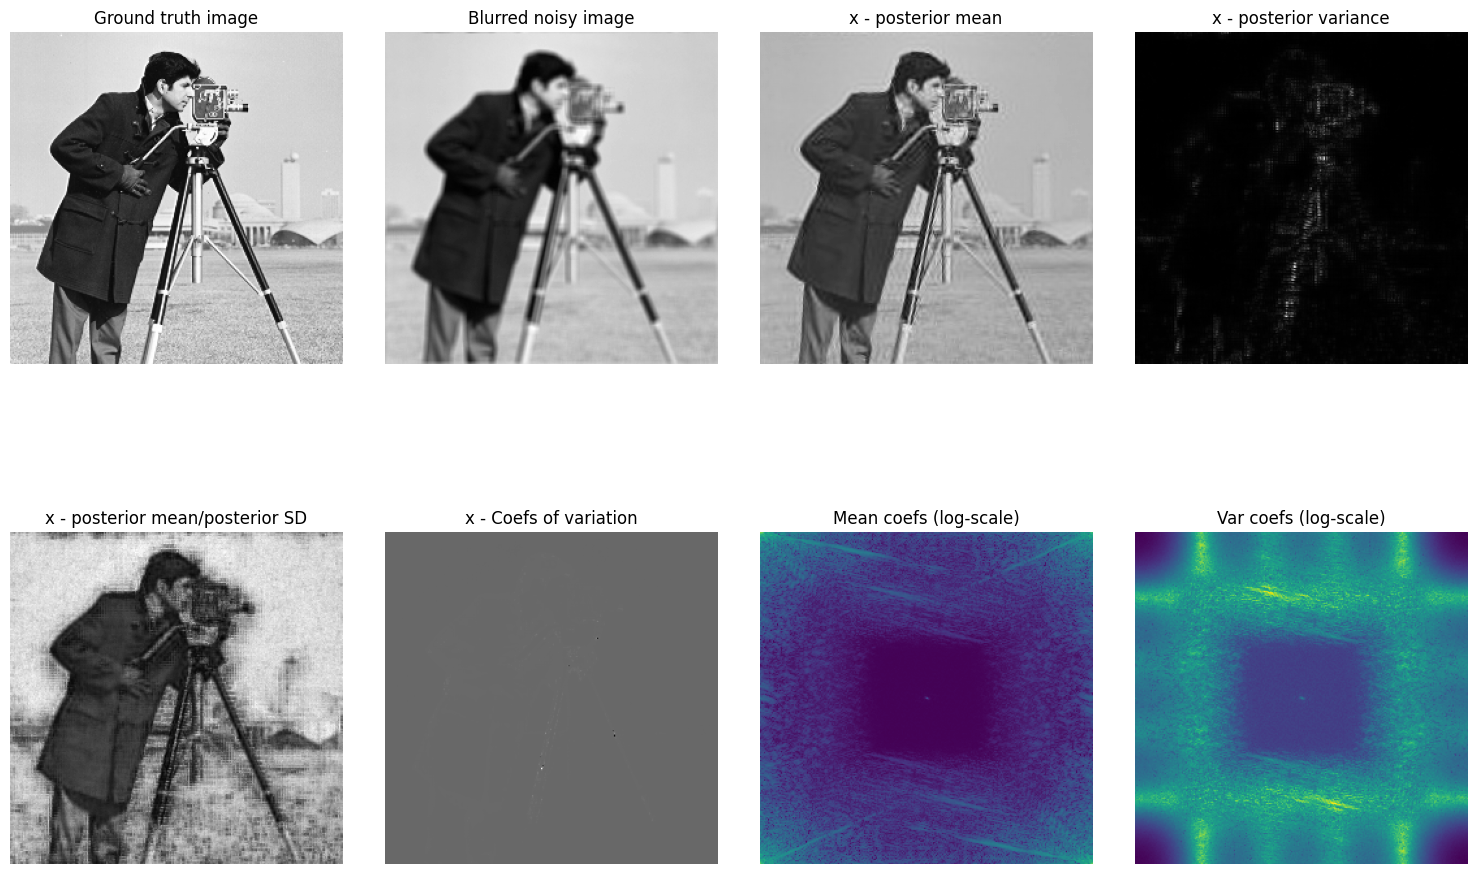

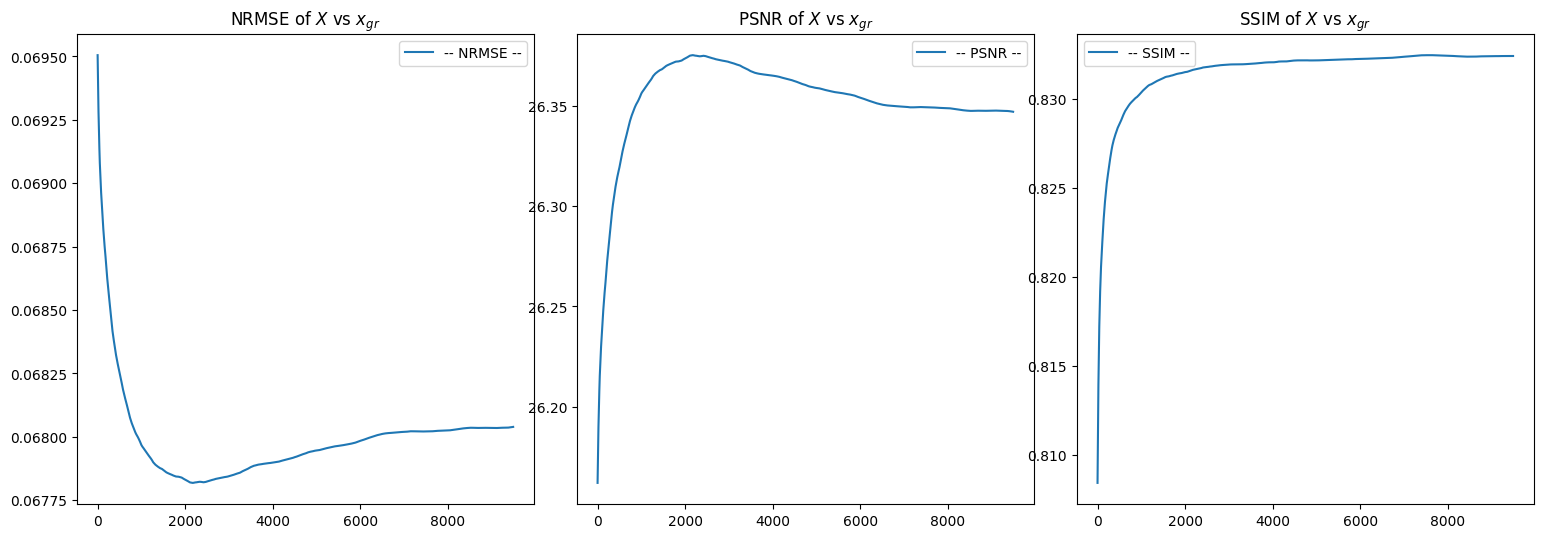

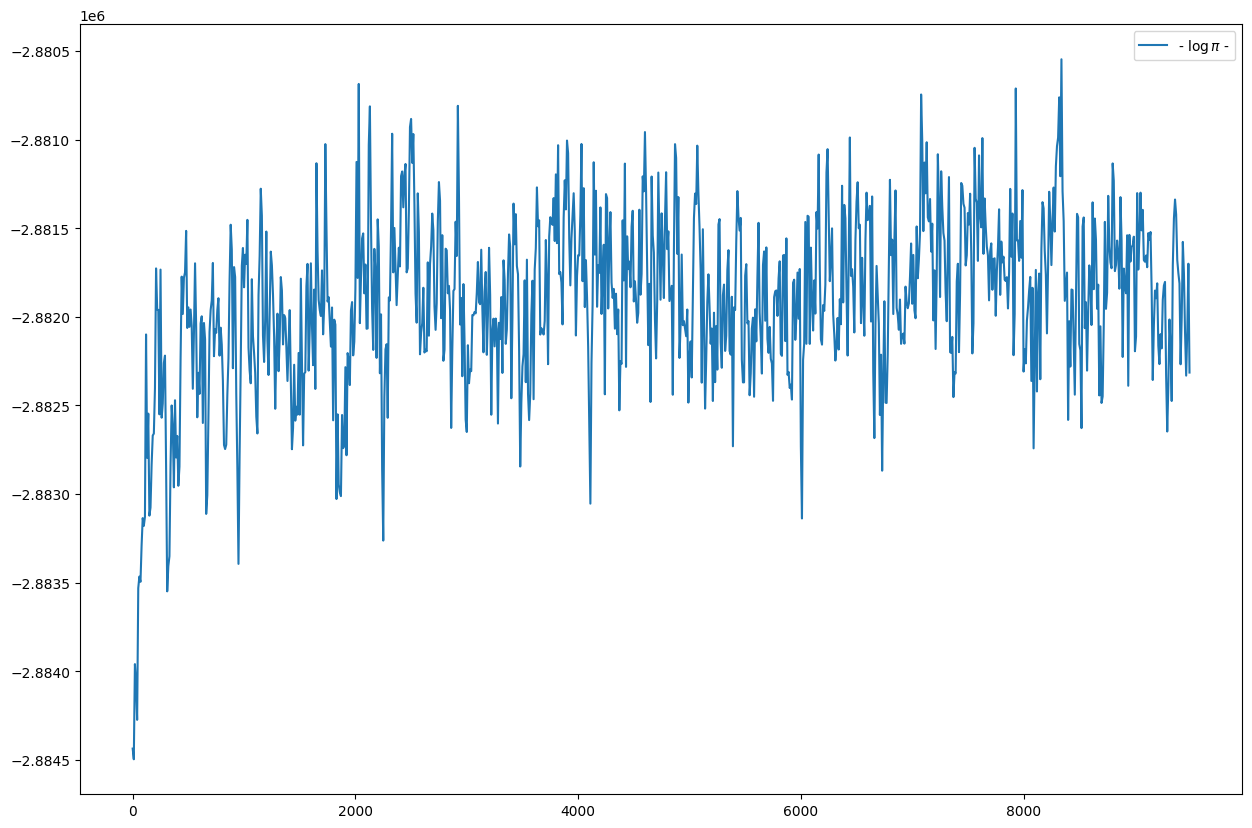

In [23]:
plots(x, y, post_meanvar, absfouriercoeff, nrmse_values, psnr_values, ssim_values, log_pi_trace)


## Autocorrelation function of the Markov chain

To analyse the convergence properties of the Markov chain generated with `ULA`, we display below the autocorrelation function of the slowest, median and fastest component of the resulting chain. We obtained the slowest component by computing the pixel index resulting in the smallest variance, and extracting a trace from the Markov chain for this pixel. Similarly, the median and fastest pixels are obtained by extracting traces from the Markov chain with the median and largest variance respectively. From where the autocorrelation drops to zero, we can see how many samples we need to generate another independent sample. Therefore we would like to see fast decay.

In addition, in the legend we give information about the effective sample size (ESS). This is also an important quantity that tells us about the quality of the chain. This number gives an indication how many independent samples are generated by the present Markov chain, and a higher number is better.

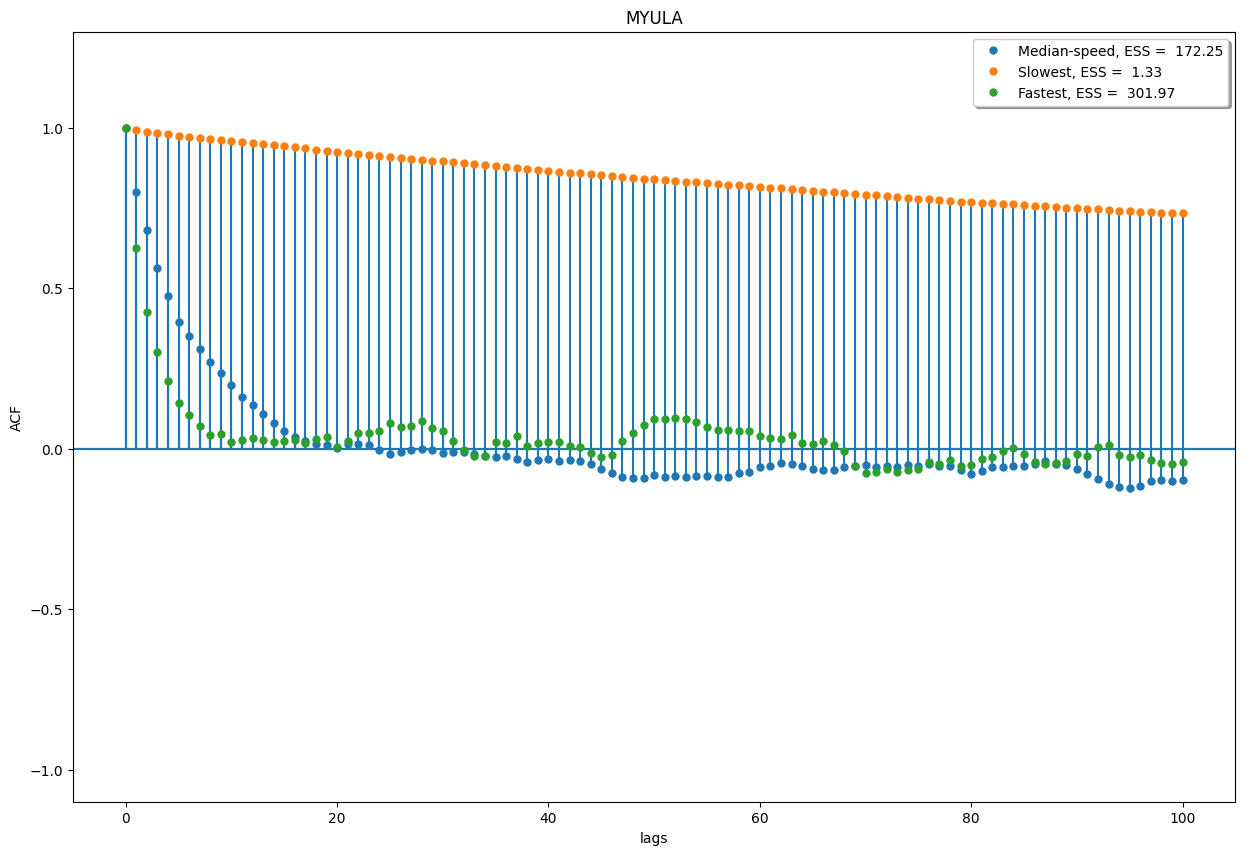

In [24]:
MC_X = np.stack(MC_X)
autocor_plots(MC_X, "MYULA")

## Uncertainty quantification

We would like to use the Markov chain to visualize the variance at different scales, giving us an indication how sure the algorithm is about the solution superpixels. Dark means lower variance and depict areas where the algorithm is sure about the solution, bright areas indicate high variance.

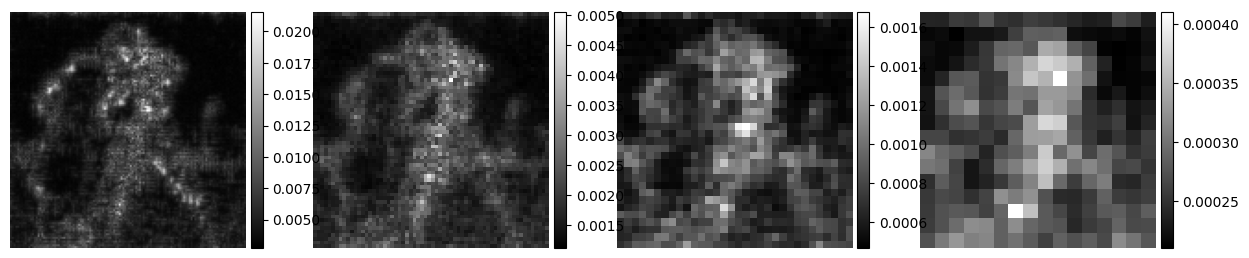

In [25]:
MC_X_array = np.array(MC_X)
shape_x = x.cpu().numpy().shape
downsampling_variance(MC_X_array.reshape(MC_X_array.shape[0], shape_x[0], shape_x[1]))


## Compute the LCI

In [32]:


MC_X_array = MC_X_array.reshape(MC_X_array.shape[0], MC_X_array.shape[2], MC_X_array.shape[3])
print(MC_X_array.shape)

(1899, 256, 256)


In [65]:

scale = [1,2,4,8]
n_samples = MC_X_array.shape[0]
nx = MC_X_array.shape[1]
ny = MC_X_array.shape[2]

saved_arrays = []
quantiles = []
means_list = []

alpha = 0.05
p = np.array([alpha, 1-alpha])

for k,i in enumerate(scale):
    
    downsample_array= np.zeros([n_samples,int(nx/(i*2)),int(ny/(i*2))])

    for j in range(n_samples):

        downsample_array[j]= ski.measure.block_reduce(MC_X_array[j], block_size=(i*2,i*2), func=np.mean)


    saved_arrays.append(downsample_array)

    quantiles.append(np.quantile(downsample_array, p, axis=0))
    means_list.append(np.mean(downsample_array, axis=0))


In [38]:
saved_arrays[0].shape

(1899, 128, 128)

In [53]:


mm = np.quantile(saved_arrays[0], p, axis=0)


In [66]:
means_list[1].shape

(64, 64)

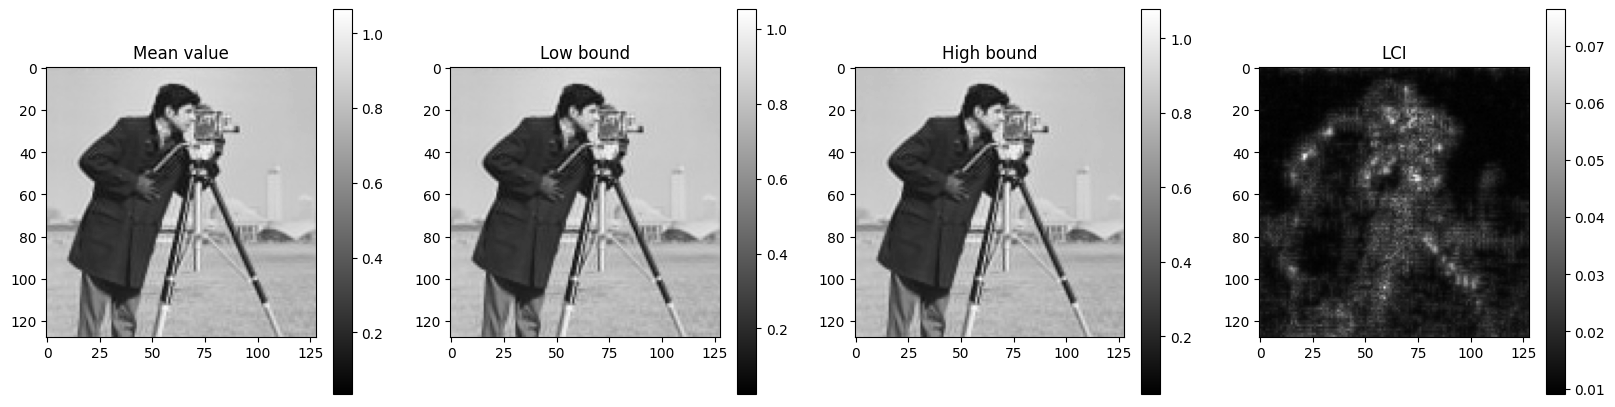

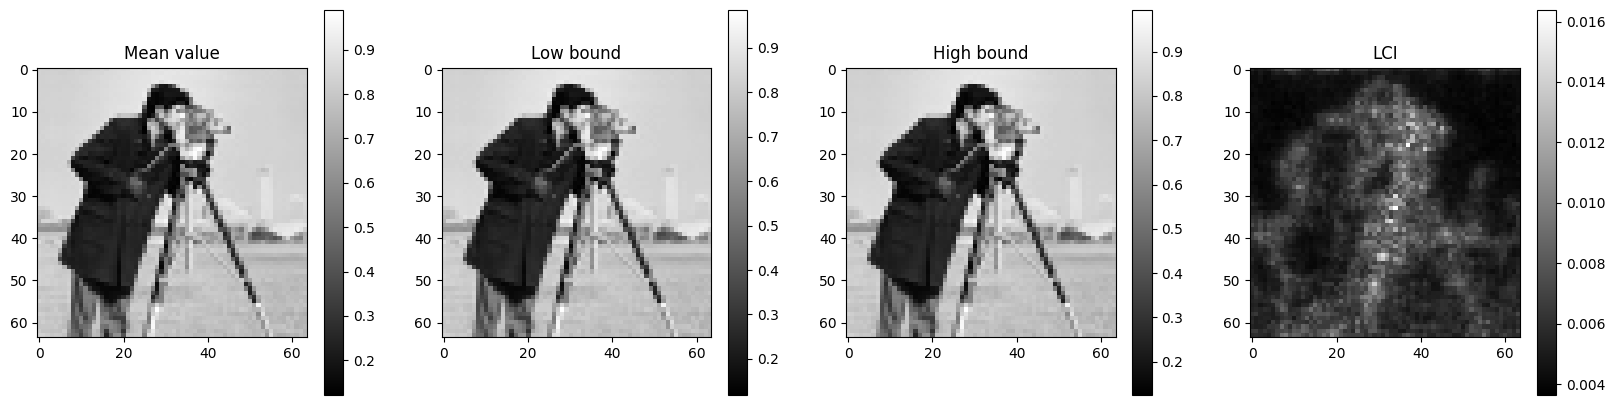

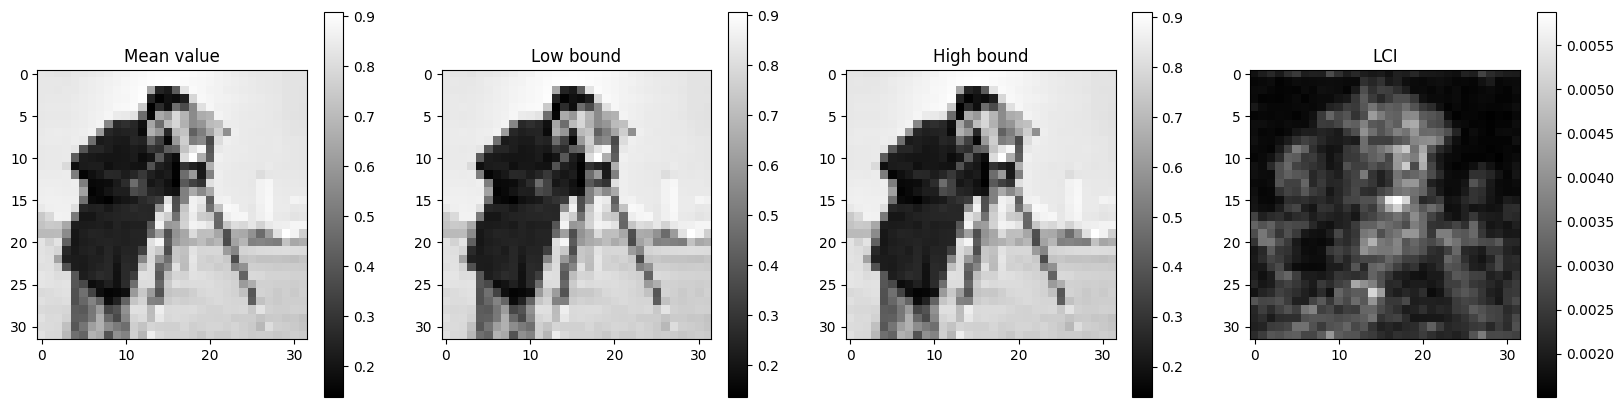

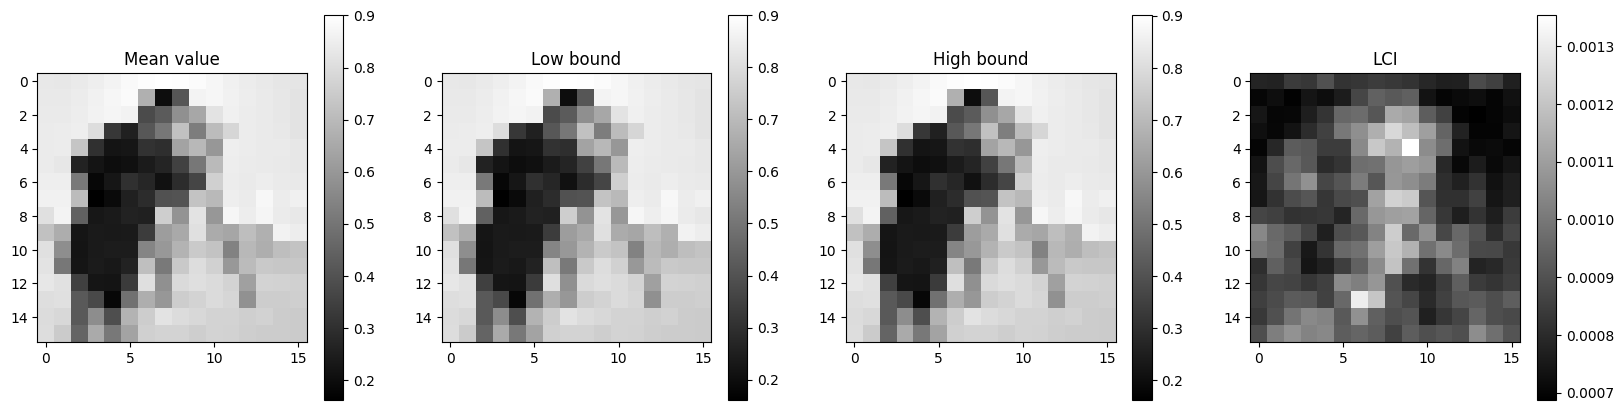

In [69]:


for it in range(len(quantiles)):

    plt.figure(figsize=(20,5))

    plt.subplot(141)
    plt.imshow(means_list[it][:,:], cmap='gray')
    plt.title('Mean value')
    plt.colorbar()

    plt.subplot(142)
    plt.imshow(quantiles[it][0,:,:], cmap='gray')
    plt.title('Low bound')
    plt.colorbar()

    plt.subplot(143)
    plt.imshow(quantiles[it][1,:,:], cmap='gray')
    plt.title('High bound')
    plt.colorbar()

    plt.subplot(144)
    plt.imshow(quantiles[it][1,:,:] - quantiles[it][0,:,:], cmap='gray')
    plt.title('LCI')
    plt.colorbar()


    plt.show()

In [47]:
saved_arrays[0].shape

(1899, 128, 128)